# Detection of Alzheimer's Disease with Neuroimaging Data Using a Shallow 2D-CNN Architecture

Man Ho Wong  
School of Computer Science  
Georgia Institute of Technology. Atlanta, GA.

--

## Introduction

This project aims to build a deep learning model to detect Alzheimer's disease with cross-sectional MRI data (more than 86,000 MRI slice images) using 2D-convoluted neural networks (CNN). Normalization and regularization techniques were used to create a stable model with good generalization performance. Despite its shallow architecture, the preliminary model developed here (SCNN4) was able to achieve an accuracy of 99.9%, a significant improvement from the current deep learning models (Zhao et al., 2023).  The training time at the moment is 18 minutes using a T4 GPU provided by Google Colab.

## Future work

Currently, the model is trained without considering class imbalance. In addition, images were split for training, validation and testing randomly without considering subject identity. The former issue may lead to a biased model (see the section "Exploring the dataset") and the latter may impact the model's generalization performance due to data leakage (Yagis et al., 2021). These issues will need to be addressed in the future. In terms of performance metrics, other metrics besides accuracy will be needed to assess the model more comprehensively, such as the model's prediction precision and generalization performance.


## Data sourcing

The training dataset was compiled by the [Open Access Series of Imaging Studies (OASIS)](https://www.oasis-brains.org/) (Marcus et al., 2007). The derived dataset was partially preprocessed by Ninad Aithal (Centre for Brain Research IISc - Bangalore, IN), including .nii to .jpg file conversion and patient classification (see [this page](https://www.kaggle.com/datasets/ninadaithal/imagesoasis/data) for more information).

## Acknowledgments

Data were provided by OASIS-1: Cross-Sectional: Principal Investigators: D. Marcus, R, Buckner, J, Csernansky J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382.

## References

Marcus, D.S., Wang, T.H., Parker, J., Csernansky, J.G., Morris, J.C., Buckner, R.L. (2007). Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults. Journal of Cognitive Neuroscience, 19, 1498-1507.  https://doi.org/10.1162/jocn.2007.19.9.1498

Yagis, E., Atnafu, S.W., García Seco de Herrera, A., Marzi C., Scheda R., Giannelli M., Tessa C., Citi L. & Diciotti S. (2021). Effect of data leakage in brain MRI classification using 2D convolutional neural networks. Nature Science Report, 11, 22544. https://doi.org/10.1038/s41598-021-0168

Zhao, Z., Chuah, J. H., Lai, K. W., Chow, C. O., Gochoo, M., Dhanalakshmi, S., Wang, N., Bao, W., & Wu, X. (2023). Conventional machine learning and deep learning in Alzheimer's disease diagnosis using neuroimaging: A review. Frontiers in computational neuroscience, 17, 1038636. https://doi.org/10.3389/fncom.2023.1038636



## Accessing the dataset in Google Colab

The dataset is publically available and can be accessed via Kaggle API as follows:

In [1]:
# # Upload kaggle.json to Google Colab
# from google.colab import files
# files.upload()

# # Kaggle API setup
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# # Download dataset
# ! kaggle datasets download -d ninadaithal/imagesoasis

# # Unzip dataset
# ! unzip -q "imagesoasis.zip" -d mri-data

# Exploring the dataset

The dataset contains MRI slice images (248px by 496px; 3 channels) of four classes according to the subject's Alzheimer's Disease diagnosis and the stage of dementia:
- Non Demented
- Very mild Dementia
- Mild Dementia
- Moderate Dementia

Image example: Mild Dementia


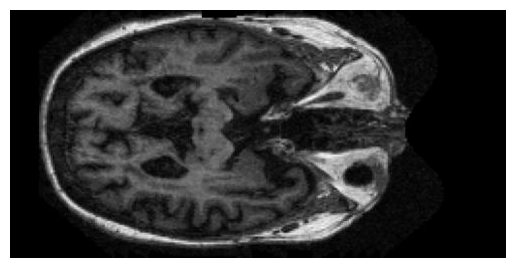

Image dimensions: (248, 496)
Number of channels: 3
Number of samples by class:
- Mild Dementia: 5002
- Moderate Dementia: 488
- Non Demented: 67222
- Very mild Dementia: 13725


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Pick a random image to display
# data_dir = '/content/mri-data/Data' # Google Colab
data_dir = '/kaggle/input/imagesoasis/Data' # Kaggle
labels = os.listdir(data_dir)
random_label = np.random.choice(labels)
random_img = np.random.choice((os.listdir(os.path.join(data_dir, random_label))))
img_path = os.path.join(data_dir, random_label, random_img)
img = plt.imread(img_path)

# Display the above image
print("Image example:", random_label)
plt.imshow(img)
plt.axis('off')
plt.show()

# Image info
print("Image dimensions:", img.shape[0:2])
print("Number of channels:", img.shape[2])

# Number of samples
print("Number of samples by class:")
for label in sorted(labels):
  print(f"- {label}: {len(os.listdir(os.path.join(data_dir, label)))}")

## Imbalanced dataset

One of the major challenges here is that the four classes have imbalanced sample sizes: The `Non Demented` class has more than 67,000 samples while the `Moderate Dementia` class has fewer than 500 samples.

Such an imbalanced sample distribution is commonly found in datasets where the minority class (in this case the subjects with dementia) occurs less frequently (or is detected less frequently) than the majority class. While an imbalanced dataset often leads to a biased model and poor predictions, this is not always the case when the minority class is well represented in the dataset, or when different classes have distinctive features that can be learned efficiently.

In this dataset, the minority class with the least number of samples, `Moderate Dementia`, is also the most severe case of dementia. Therefore, it is reasonable to expect that the difference between this class and the majority class, `Non Demented`, is the most significant among all pairs of classes. Given that Alzheimer's Disease has been shown to be detectable through MRI structural features (e.g. relative sizes of different brain regions), it is likely that the minority class here has the most distinctive features. Assuming that these features are learnable through deep learning and that every class is well represented in the dataset, I will first build the model without balancing the minority and majority classes. To prevent overfitting due to imbalanced dataset, common regularization techniques (e.g. dropout) will be used.



# Data preprocessing

The dataset used in this project contains jpg images with three color channels. Since MRI data records only one channel, we will convert the images to grayscale (one channel) to save computing resources and speed up the training process. We will then transform the images to PyTorch tensors.

The dataset will be split into three separate datasets for training (70%), validation (20%) and testing (10%). Each dataset should cover all four classes with this split ratio.


## Transform images and load them into tensors

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt

# List of transforms
tf_list = tt.Compose([tt.Grayscale(), # Source files (jpg) has 3 channels. Convert them to grayscale.
                      tt.ToTensor()])

dataset = ImageFolder(data_dir, tf_list)

## Split the dataset for training, validation, and testing

In [4]:
import torch
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

# Set the random seed for reproducible datasets
random_seed = 42
torch.manual_seed(random_seed)

# Split dataset
train_size = 0.7
val_size = 0.2
test_size = 0.1
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size=100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*4, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*4, num_workers=2, pin_memory=True)

## Move data to GPU

In [5]:
# Wrap data loader with this to move it to a new device
class relocated_dl():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Move data by yielding data batch by batch"""
        for batch in self.dl:
            yield move_data(batch, self.device)
    def __len__(self):
        return len(self.dl)

# Helper function
def move_data(data, device):
    if isinstance(data, (list, tuple)):
        return [move_data(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = torch.device('cuda')
train_dl = relocated_dl(train_dl, device)
val_dl = relocated_dl(val_dl, device)
test_dl = relocated_dl(test_dl, device)

# The model

## Define the model base

In [6]:
# Extend nn.Module to create a model base
# All models will use the same model base regardless of architecture.

import torch.nn as nn
import torch.nn.functional as F

class ModelBase(nn.Module):
    def train_phase(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        return loss

    def eval_phase(self, batch):
        imgs, labels = batch
        out = self(imgs)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels) # see below
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def epoch_stat(self, epoch_out):
        epoch_loss = torch.stack([x['val_loss'] for x in epoch_out]).mean()
        epoch_acc = torch.stack([x['val_acc'] for x in epoch_out]).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def print_stat(self, epoch, stat):
        print("Epoch {} -- last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, stat['lrs'][-1], stat['train_loss'], stat['val_loss'], stat['val_acc']))

## Define the metric for model performance

For more intuitive interpretation, we will use accuracy (percentage of correctly predicted labels) to measure model performance for now. Other metrics may be used later depending on model performance.

In [7]:
# Helper function
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))


## Create a new model class with `ModelBase`

### Neural network layers

The following model (`SCNN4`) contains four CNN layers of increasing channel numbers. The intermediate feature maps generated by the last CNN layer is flattened and forwarded to a linear network as the final layer.

### Activation layer

ReLU is used as the activation layer between the neural network layers.

### Normalization and regularization

To create a more stable model, a batch normalization layer is added after each CNN layer. In addition, a dropout layer is added before the final linear layer to prevent overfitting by dropping 20% of nodes randomly.

### Max pooling

To speed up training, a max pooling layer is added to reduce the dimensions of input feature maps to each neural network layer (except the input to the first two CNN layers).

Visualization of the model:

<!-- ![model](./img/alzheimers-model.png) -->
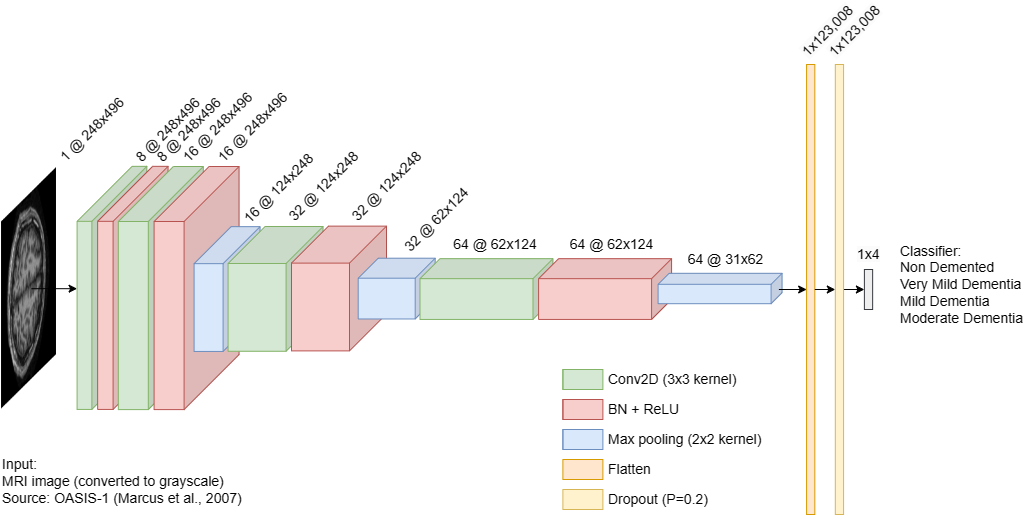

In [8]:
# Create a new model class by extending the class ModelBase
# Spefify the model architecture here.

class SCNN4(ModelBase):

    def __init__(self, in_ch, n_classes):
        super().__init__()                          # Size of each input tensor (channels, rows, columns):
        self.cnn1 = cnn_block(in_ch, 8, pool=False) # 1,248,496
        self.cnn2 = cnn_block(8, 16, pool=True)     # 8,248,496
        self.cnn3 = cnn_block(16, 32, pool=True)    # 16,124,248
        self.cnn4 = cnn_block(32, 64, pool=True)    # 32,61,124
        self.last = nn.Sequential(nn.Flatten(),     # 64,31,62
                                  nn.Dropout(0.2),
                                  nn.Linear(64*31*62, n_classes))

    def forward(self, xb):
        out = self.cnn1(xb)
        out = self.cnn2(out)
        out = self.cnn3(out)
        out = self.cnn4(out)
        out = self.last(out)
        return out

# Helper function
def cnn_block(in_ch, out_ch, pool=False):
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_ch),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# Model training


## Define the training steps

Note that weight decay and learning rate scheduling are employed in the following training process.

In [9]:
# Model fitting involves a training phase and a validation phase
# (Code adapted from https://jovian.ai/aakashns/05b-cifar10-resnet)

def fit(model, train_dl, val_dl, n_epochs, max_lr,
        weight_decay=0, opt_func=torch.optim.SGD
        ):

    torch.cuda.empty_cache()

    # Custom optimizer
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # One cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=n_epochs,
                                                    steps_per_epoch=len(train_dl))

    history = []
    for epoch in range(n_epochs):

        # Training phase
        model.train() # Declare training phase
        train_losses = []
        lrs = []
        for batch in train_dl:
            loss = model.train_phase(batch)
            train_losses.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()
            lrs.append(get_lr(opt))
            scheduler.step()

        # Validation phase
        stat = evaluate(model, val_dl)

        # Summarize epoch statistics
        stat['train_loss'] = torch.stack(train_losses).mean().item()
        stat['lrs'] = lrs
        model.print_stat(epoch+1, stat)

        # Save training history
        history.append(stat)

    return history

# Helper functions

@torch.no_grad() # tell PyTorch NOT to compute gradidents for evaluate()
def evaluate(model, dataloader):
    model.eval() # declare model evaluation (no randomization needed)
    epoch_out = [model.eval_phase(batch) for batch in dataloader]
    return model.epoch_stat(epoch_out)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Training

Adjust the hyperparameters here.

In [10]:
# Instantiate a model and move it to GPU
model = move_data(SCNN4(1, 4), device)

# Hyperparameters
n_epochs = 4
max_lr = 0.003
weight_decay = 1e-4
opt_func = torch.optim.Adam

history = fit(model, train_dl, val_dl,
              n_epochs,
              max_lr,
              weight_decay,
              opt_func
              )

Epoch 1 -- last_lr: 0.002807, train_loss: 0.7837, val_loss: 0.3009, val_acc: 0.9261
Epoch 2 -- last_lr: 0.002435, train_loss: 0.1025, val_loss: 0.0430, val_acc: 0.9838
Epoch 3 -- last_lr: 0.000849, train_loss: 0.0131, val_loss: 0.0044, val_acc: 0.9987
Epoch 4 -- last_lr: 0.000000, train_loss: 0.0018, val_loss: 0.0033, val_acc: 0.9993


# Model evaluation with test dataset

In [11]:
stat = evaluate(model, test_dl)
stat

{'val_loss': 0.003962568938732147, 'val_acc': 0.9993181228637695}

## Predict image labels using the model

In [12]:
def predict_label(img, model):
    xb = move_data(img.unsqueeze(0), # unsqueeze img to add a dimension (model only reads a batch of images)
                   device)           # move img to GPU
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for batch in test_dl:
  for i in range(10): # Predict first 10 images in the first batch of test_dl
    img = batch[0][i]
    label = batch[1][i]
    print('| Predicted:', predict_label(img, model),
          'Label:', dataset.classes[label])
  break

| Predicted: Non Demented Label: Non Demented
| Predicted: Very mild Dementia Label: Very mild Dementia
| Predicted: Non Demented Label: Non Demented
| Predicted: Non Demented Label: Non Demented
| Predicted: Very mild Dementia Label: Very mild Dementia
| Predicted: Non Demented Label: Non Demented
| Predicted: Non Demented Label: Non Demented
| Predicted: Non Demented Label: Non Demented
| Predicted: Very mild Dementia Label: Very mild Dementia
| Predicted: Non Demented Label: Non Demented


# Saving the trained parameters

In [13]:
torch.save(model.state_dict(), 'scnn4.pth')

# To load the saved model:
# model2 = move_data(SCNN4(1,4), device)
# model2.load_state_dict(torch.load('scnn4.pth'))

In [14]:
# torch.cuda.empty_cache()
# total = torch.cuda.get_device_properties(0).total_memory
# reserved = torch.cuda.memory_reserved(0)
# allocated = torch.cuda.memory_allocated(0)
# free = reserved - allocated
# print(total, reserved, allocated, free